In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
from scipy import interp
import re
import string
from collections import Counter
from pandas.io.json import json_normalize
import dask.bag as db
import json
import h5py
import warnings # Turn off warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, label_binarize, normalize
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from sklearn.metrics import f1_score, auc, roc_auc_score, roc_curve, precision_score, recall_score, accuracy_score, precision_recall_curve, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import VotingClassifier, AdaBoostClassifier, BaggingRegressor
from mlxtend.classifier import StackingClassifier
from sklearn.decomposition import NMF
from sklearn.base import BaseEstimator, TransformerMixin

# Logistic regression works the best
# GaussianNB, DecisionTree, and RandomForest are poor
# SVC and XGBoost will crash

import gensim
from gensim import corpora, models, similarities, matutils
from gensim.models import Word2Vec
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS

In [2]:
class TextSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

In [3]:
def flatten_review(bag):
    """
    Columns in review.json: 'review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny', 'cool', 'text', 'date'
    """
    return {
        'date': bag['date'],
        'business_id': bag['business_id'],
        'useful': bag['useful'],
        'funny': bag['funny'],
        'cool': bag['cool'],
        'text': bag['text'],
        'stars': bag['stars']
    }

def flatten_business(bag):
    """
    Columns in review.json:
    'business_id', 'link_id', 'name',
    'address', 'city','state', 'postal_code', 'telephone', 'latitude',  'longitude',
    'stars', 'review_count', 'is_open',
    'attributes', 'categories', 'hours'
    """
    return {
        'business_id': bag['business_id'],
        'link_id': bag['link_id'],
        'name': bag['name'],
        'stars': bag['stars'],
        'review_count': bag['review_count'],
        'attributes': bag['attributes'],
        'categories': bag['categories'],
        'hours': bag['hours']
    }



def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        
        
        
def grab_topics(model, feature_names, no_top_words, topic_names=None):
    
    topic_list = []
    
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            None
            #print("\nTopic ", ix)
        else:
            None
            #print("\nTopic: '",topic_names[ix],"'")
        topic_str = ", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]])
        topic_list.append(topic_str)
    return topic_list

# Import Data

In [4]:
# Load JSON Data
review_full_bag = db.read_text("data/climbing-gym-reviews.json").map(json.loads) # Loads the json file as a dask bag
review_tuple = review_full_bag.take(10000) # Takes the first 10000 entries of the dask bag and stores as a tuple
review_bag = db.from_sequence(review_tuple, npartitions=1) # Converts back to bag for flattening
review_selected_tuple = review_bag.map(flatten_review).take(10000) # Grab important features
review_selected_df = json_normalize(list(review_selected_tuple)) # Convert tuple to dataframe

# Convert date to datetime object
review_selected_df.date = review_selected_df.date.apply(lambda x : dt.datetime.strptime(x, "%m/%d/%Y")) # Convert to datetime object

# Add text_length column
review_selected_df['text_length'] = review_selected_df['text'].apply(len)

# Clean Text
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())
review_selected_df['text_clean'] = review_selected_df.text.map(alphanumeric).map(punc_lower)

review_selected_df.head() # Display filtered dataframe

,business_id,cool,date,funny,stars,text,useful,text_length,text_clean
0,3J-Q42JoMUPqRHfUckA2bw,0,2018-12-22,0,5,So far I like this place. The coaches are awes...,0,287,so far i like this place the coaches are awes...
1,3J-Q42JoMUPqRHfUckA2bw,0,2019-05-21,0,5,We love this place! You are greeted by staff w...,0,529,we love this place you are greeted by staff w...
2,3J-Q42JoMUPqRHfUckA2bw,1,2018-10-02,0,4,Had a nice climb here! I don't go climbing oft...,0,460,had a nice climb here i don t go climbing oft...
3,3J-Q42JoMUPqRHfUckA2bw,0,2019-04-19,0,5,This place is great. It's like walking into t...,0,409,this place is great it s like walking into t...
4,3J-Q42JoMUPqRHfUckA2bw,0,2019-03-29,0,5,I had never rock climbed and came with a frien...,0,706,i had never rock climbed and came with a frien...


In [6]:
# Load JSON Data
business_full_bag = db.read_text("data/climbing-gym-business.json").map(json.loads) # Loads the json file as a dask bag
business_tuple = business_full_bag.take(10000) # Takes the first 10000 entries of the dask bag and stores as a tuple
business_bag = db.from_sequence(business_tuple, npartitions=1) # Converts back to bag for flattening
business_selected_tuple = business_bag.map(flatten_business).take(10000) # Take turns it into a tuple
business_selected_df = json_normalize(list(business_selected_tuple)) # Convert tuple to dataframe

# Some preprocessing
business_selected_df.columns = business_selected_df.columns.str.replace('attributes.', '')
business_selected_df.columns = business_selected_df.columns.str.replace('hours.', '')
business_selected_df = business_selected_df.rename(columns = {'stars': 'avg_stars'}) # Prevent conflict with review_df
business_selected_df = business_selected_df.fillna(value = 0)
business_selected_df = business_selected_df.replace(to_replace=['Yes', 'No'], value=[1, 0])
business_selected_df

business_selected_df.head() # Display filtered dataframe

,attributes,Accepts Apple Pay,Accepts Credit Cards,Accepts Cryptocurrency,Accepts Google Pay,Bike Parking,Cannabis Products,Dogs Allowed,Good for Kids,Offers Military Discount,...,Mon,Sat,Sun,Thu,Tue,Wed,link_id,name,review_count,avg_stars
0,0.0,0,1,0,0,1,0,0,1,0,...,12:00 pm - 11:00 pm,10:00 am - 10:00 pm,10:00 am - 6:00 pm,12:00 pm - 11:00 pm,12:00 pm - 11:00 pm,12:00 pm - 11:00 pm,aesthetic-climbing-gym-lake-forest,Aesthetic Climbing Gym,66,4.5
1,0.0,0,1,0,0,1,0,0,1,0,...,6:00 am - 11:00 pm,8:00 am - 8:00 pm,8:00 am - 8:00 pm,6:00 am - 11:00 pm,6:00 am - 11:00 pm,6:00 am - 11:00 pm,berkeley-ironworks-climbing-and-fitness-club-b...,Berkeley Ironworks Climbing & Fitness Club,310,4.0
2,0.0,0,0,0,0,0,0,0,0,0,...,6:00 am - 10:00 pm,9:00 am - 10:00 pm,9:00 am - 10:00 pm,6:00 am - 10:00 pm,6:00 am - 10:00 pm,6:00 am - 10:00 pm,blue-granite-climbing-gym-south-lake-tahoe,Blue Granite Climbing Gym,9,5.0
3,0.0,0,1,0,0,1,0,0,1,0,...,11:00 am - 10:00 pm,10:00 am - 8:00 pm,10:00 am - 6:00 pm,11:00 am - 10:00 pm,11:00 am - 10:00 pm,11:00 am - 10:00 pm,boulderdash-indoor-rock-climbing-thousand-oaks,Boulderdash Indoor Rock Climbing,99,4.0
4,0.0,0,0,0,0,1,0,0,1,0,...,11:00 am - 10:00 pm,10:00 am - 8:00 pm,10:00 am - 6:00 pm,11:00 am - 10:00 pm,11:00 am - 10:00 pm,11:00 am - 10:00 pm,boulderdash-sfv-chatsworth-6,Boulderdash SFV,60,4.5


In [7]:
# Merge data
business_review_df = pd.merge(business_selected_df, review_selected_df, on="business_id")

In [8]:
business_review_df.columns

Index(['attributes', 'Accepts Apple Pay', 'Accepts Credit Cards',
       'Accepts Cryptocurrency', 'Accepts Google Pay', 'Bike Parking',
       'Cannabis Products', 'Dogs Allowed', 'Good for Kids',
       'Offers Military Discount', 'Open to All', 'Parking',
       'Wheelchair Accessible', 'Wi-Fi', 'business_id', 'categories', 'hours',
       'Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed', 'link_id', 'name',
       'review_count', 'avg_stars', 'cool', 'date', 'funny', 'stars', 'text',
       'useful', 'text_length', 'text_clean'],
      dtype='object')

In [9]:
len(business_review_df)

8317

# Topic Modeling

In [10]:
# Pick out text for NMF
features_ser = business_review_df['text_clean']

In [11]:
class_1_ser = business_review_df[business_review_df['stars'] == 1]['text_clean']
class_2_ser = business_review_df[business_review_df['stars'] == 2]['text_clean']
class_3_ser = business_review_df[business_review_df['stars'] == 3]['text_clean']
class_4_ser = business_review_df[business_review_df['stars'] == 4]['text_clean']
class_5_ser = business_review_df[business_review_df['stars'] == 5]['text_clean']

In [12]:
# Count Vectorizer
count_vectorizer = CountVectorizer(stop_words='english', ngram_range=(1,3))
features_vectorized_csr = count_vectorizer.fit_transform(features_ser) # csr

In [13]:
features_vectorized_csr

<8317x720127 sparse matrix of type '<class 'numpy.int64'>'
	with 1340614 stored elements in Compressed Sparse Row format>

In [14]:
# Tfidf
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,3), stop_words='english')
features_tfidf_vectorized_csr = tfidf_vectorizer.fit_transform(features_ser)

In [15]:
features_tfidf_vectorized_csr

<8317x720127 sparse matrix of type '<class 'numpy.float64'>'
	with 1340614 stored elements in Compressed Sparse Row format>

# 5-Star Reviews

In [16]:
# Count Vectorizer
count_vectorizer_5 = CountVectorizer(stop_words='english', ngram_range=(1,3))
class_5_vectorized_csr = count_vectorizer_5.fit_transform(class_5_ser)

nmf_model = NMF(10)
doc_topic = nmf_model.fit_transform(class_5_vectorized_csr)
topic_word = pd.DataFrame(nmf_model.components_.round(3),
             index = ["component_1","component_2", "component_3", "component_4", "component_5",
                      "component_6","component_7", "component_8", "component_9", "component_10"],
             columns = count_vectorizer_5.get_feature_names())

display_topics(nmf_model, count_vectorizer_5.get_feature_names(), 100)


Topic  0
time, climb, kids, day, belay, fun, class, got, party, definitely, walls, pass, did, went, wall, took, try, sure, come, just, make, little, didn, came, birthday, room, instructor, shoes, easy, pretty, friend, day pass, different, experience, lesson, way, hour, safety, old, going, able, groupon, bit, use, son, super, hours, lot, free, know, friends, wait, year, right, ll, birthday party, wanted, check, don, good, want, patient, make sure, great time, night, harness, doing, rope, loved, said, gave, bring, recommend, daughter, parents, group, year old, let, safe, thanks, having, levels, sore, rental, facility, awesome, climbs, climbed, felt, think, big, auto, tie, learn, intro, course, person, bouldering, ropes, decided

Topic  1
gym, climbing gym, bouldering, gyms, area, climb, best, problems, walls, parking, new, home, good, people, day, clean, membership, equipment, small, nice, come, la, touchstone, bouldering gym, weights, open, just, lot, gym ve, better, regular, favorite,

In [17]:
# TF-IDF, gives similar results as Count Vectorizer
tfidf_vectorizer_5 = TfidfVectorizer(stop_words='english', ngram_range=(1,3))
features_tfidf_vectorized_csr = tfidf_vectorizer_5.fit_transform(class_5_ser)

nmf_model = NMF(10)
doc_topic = nmf_model.fit_transform(features_tfidf_vectorized_csr)
topic_word = pd.DataFrame(nmf_model.components_.round(3),
             index = ["component_1","component_2", "component_3", "component 4", "component 5",
                      "component_6","component_7", "component_8", "component_9", "component_10"],
             columns = tfidf_vectorizer_5.get_feature_names())


display_topics(nmf_model, tfidf_vectorizer_5.get_feature_names(), 100)


Topic  0
really, day, like, time, place, pass, people, just, good, climb, fun, come, day pass, don, got, shoes, definitely, pretty, membership, went, try, friend, lot, feel, climbing, cool, work, wall, friends, want, know, going, free, walls, make, ve, ll, different, way, came, chalk, nice, little, month, harness, sure, didn, rental, times, help, think, shoe, belay, did, use, say, workout, need, body, super, doing, night, levels, able, coming, getting, started, let, climbers, awesome, deal, felt, worth, bring, new, feel like, beginner, easy, bouldering, guest, days, climbs, thing, check, week, bit, student, hours, lesson, things, better, gear, groupon, gym, working, level, wasn, probably, climbed, beginners

Topic  1
class, belay, took, instructor, intro, time, climbing, groupon, recommend, belay class, highly, experience, highly recommend, intro class, lesson, climbing class, patient, climb, fun, safety, learn, took belay, took intro, got, took belay class, great, did, went, rope, ca

In [18]:
topics_5 = grab_topics(nmf_model, count_vectorizer_5.get_feature_names(), 100)

In [19]:
STOPWORDS.add('climbing')
STOPWORDS.add('gym')
STOPWORDS.add('mesa')

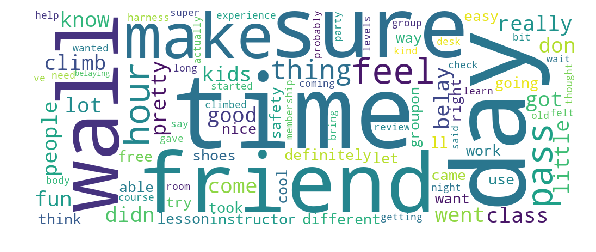

In [621]:
wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white',width=1000,height=400).generate(topics_5[0])
plt.figure(figsize=(10,4))
plt.imshow(wordcloud)
plt.axis('off')
#plt.savefig("figures/topic-modeling/word-cloud-5_star-0.png", transparent=True, bbox_inches="tight")

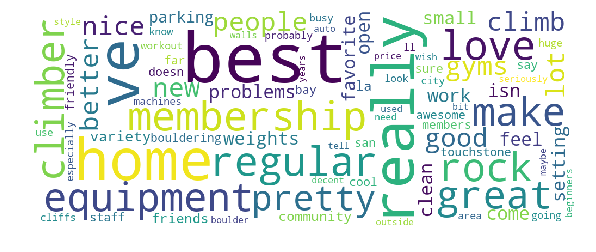

In [623]:
wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white',width=1000,height=400).generate(topics_5[1])
plt.figure(figsize=(10,4))
plt.imshow(wordcloud)
plt.axis('off')
#plt.savefig("figures/topic-modeling/word-cloud-5_star-1.png", transparent=True, bbox_inches="tight")

# 1-Star Reviews

In [20]:
# Count Vectorizer
count_vectorizer_1 = CountVectorizer(stop_words='english', ngram_range=(1,3))
class_1_vectorized_csr = count_vectorizer_1.fit_transform(class_1_ser)

nmf_model_1 = NMF(10)
doc_topic = nmf_model_1.fit_transform(class_1_vectorized_csr)
topic_word = pd.DataFrame(nmf_model_1.components_.round(3),
             index = ["component_1","component_2", "component_3", "component_4", "component_5",
                      "component_6","component_7", "component_8", "component_9", "component_10"],
             columns = count_vectorizer_1.get_feature_names())

display_topics(nmf_model_1, count_vectorizer_1.get_feature_names(), 100)


Topic  0
climbing, gym, just, kids, ve, staff, routes, don, area, gyms, like, climbing gym, lead, really, route, climbers, good, way, members, climb, member, place, time, rude, know, children, weight, day, safety, years, great, walls, bad, want, membership, bouldering, rock, belay, lead climbing, dangerous, told, did, make, feel, bridges, behavior, dirty, worst, climber, work, staff member, safe, things, care, holds, easy, couple, gyms ve, better, hard, wall, experience, rope, staffs, usually, best, come, actually, old, little, money, far, thing, nice, looking, training, tell, didn, yoga, owner, heavier, doesn, ll, person, seen, ropes, thought, times, weights, compensating weight, compensating, training area, going, months, help, tried, business, new, year, incredibly

Topic  1
room, hotel, valet, night, stay, like, did, don, old, rooms, beach, view, desk, service, ocean, car, parking, nice, staff, bathroom, small, door, bed, just, check, looked, motel, shower, morning, stayed, carpet

In [21]:
# TF-IDF
tfidf_vectorizer_1 = TfidfVectorizer(stop_words='english', ngram_range=(1,3))
features_tfidf_vectorized_csr = tfidf_vectorizer_1.fit_transform(class_1_ser)

nmf_model = NMF(10)
doc_topic = nmf_model.fit_transform(features_tfidf_vectorized_csr)
topic_word = pd.DataFrame(nmf_model.components_.round(3),
             index = ["component_1","component_2", "component_3", "component 4", "component 5",
                      "component_6","component_7", "component_8", "component_9", "component_10"],
             columns = tfidf_vectorizer_1.get_feature_names())

display_topics(nmf_model, tfidf_vectorizer_1.get_feature_names(), 100)


Topic  0
gym, climbing, belay, routes, staff, climb, rope, ve, test, gyms, don, just, area, place, holds, route, lead, like, people, climber, way, time, climbers, bouldering, safety, good, climbing gym, really, ropes, mission, years, new, hold, cliffs, set, walls, feel, wall, mission cliffs, worst, know, member, partner, belaying, experience, mesa, want, members, love, better, technique, used, make, probably, unsafe, tape, seen, staff member, did, old, belay test, lead climbing, far, pretty, rude, maybe, climbs, great, doesn, san, gri, use, going, started, bay, getting, actually, climbing years, hard, look, fall, long, asked, thing, wrong, dirty, rock, things, pass, dangerous, need, safe, climbed, harness, weight, climbing gyms, completely, feet, big, setting

Topic  1
room, hotel, night, stay, rooms, ocean, beach, view, valet, old, stayed, motel, booked, place, bathroom, pool, like, desk, small, did, dirty, carpet, door, parking, bed, check, nice, laguna, price, shower, ocean view, c

In [28]:
topics_1 = grab_topics(nmf_model, tfidf_vectorizer_1.get_feature_names(), 100)

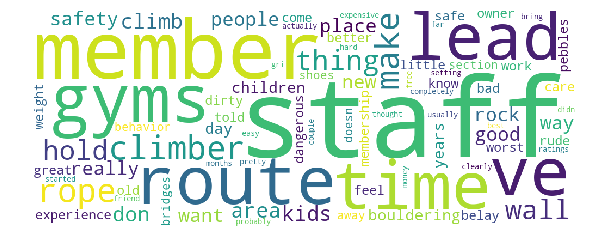

In [620]:
wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white',width=1000,height=400).generate(topics_1[0])
plt.figure(figsize=(10,4))
plt.imshow(wordcloud)
plt.axis('off')
#plt.savefig("figures/topic-modeling/word-cloud-1_star-0.png", transparent=True, bbox_inches="tight")

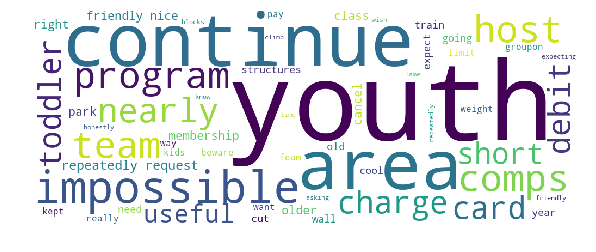

In [30]:
wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white',width=1000,height=400).generate(topics_1[2])
plt.figure(figsize=(10,4))
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig("figures/topic-modeling/word-cloud-1_star-2.png", transparent=True, bbox_inches="tight")

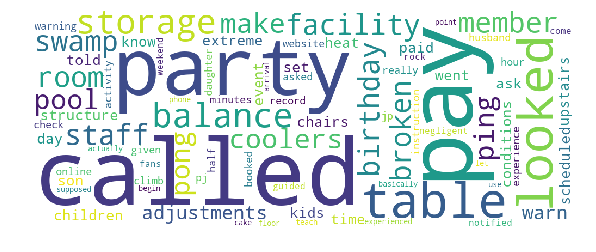

In [619]:
wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white',width=1000,height=400).generate(topics_1[3])
plt.figure(figsize=(10,4))
plt.imshow(wordcloud)
plt.axis('off')
#plt.savefig("figures/topic-modeling/word-cloud-1_star-3.png", transparent=True, bbox_inches="tight")